In [1]:
import os
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,373 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,069 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backport

In [2]:
# Import CSV file utilizing PySpark
path = 'INNHotelsGroup.csv'
spark.sparkContext.addFile(path)
df = spark.read.csv(path, header=True, sep=',')
df.show()

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+--

## Examine important features impacting Booking Status/ cancellations

In [3]:
#convert to Pandas dataframe
import pandas as pd
import datetime
pd_df = df.toPandas()

#Data cleaning steps

#Convert columns to numeric values
room_type_dummies = pd.get_dummies(pd_df["room_type_reserved"], dtype=int)
meal_plan_dummies = pd.get_dummies(pd_df["type_of_meal_plan"], dtype=int)
pd_df = pd.concat([pd_df, meal_plan_dummies, room_type_dummies], axis=1)
pd_df = pd_df.drop(columns=["type_of_meal_plan", "room_type_reserved"])

# Replace string values with boolean values to make data easier to use
def encode_market(market):
    if market == "Online":
        return 1
    else:
        return 0

def encode_cancel(cancel):
    if cancel == "Canceled":
        return 1
    else:
        return 0

# Call the encode_cancel function on the cancel column
pd_df["booking_status"] = pd_df["booking_status"].apply(encode_cancel)
pd_df["market_segment_type"] = pd_df["market_segment_type"].apply(encode_market)

# Set index of cleaned_df
pd_df.set_index("Booking_ID", inplace=True)

pd_df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,...,Meal Plan 2,Meal Plan 3,Not Selected,Room_Type 1,Room_Type 2,Room_Type 3,Room_Type 4,Room_Type 5,Room_Type 6,Room_Type 7
Booking_ID,,,,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,0,224,2017,10,2,0,...,0,0,0,1,0,0,0,0,0,0
INN00002,2,0,2,3,0,5,2018,11,6,1,...,0,0,1,1,0,0,0,0,0,0
INN00003,1,0,2,1,0,1,2018,2,28,1,...,0,0,0,1,0,0,0,0,0,0
INN00004,2,0,0,2,0,211,2018,5,20,1,...,0,0,0,1,0,0,0,0,0,0
INN00005,2,0,1,1,0,48,2018,4,11,1,...,0,0,1,1,0,0,0,0,0,0


<Axes: title={'center': 'Features Importance'}, ylabel='1'>

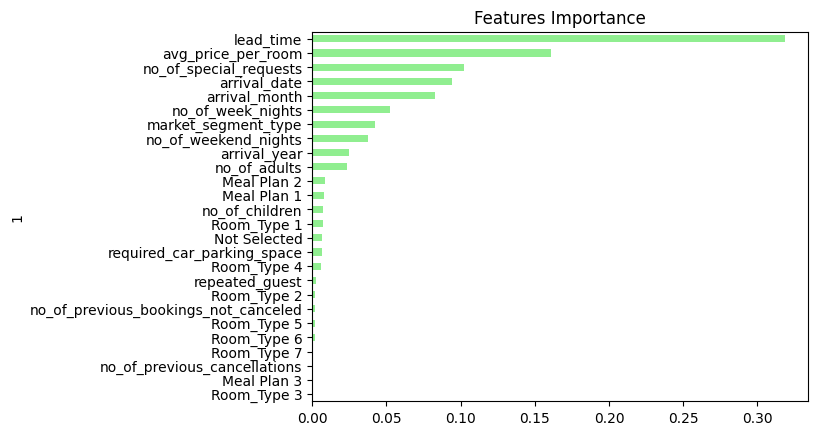

In [5]:
#Creating Random Forest model to assess important features


# Import dependencies for Machine Learning Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
# Split our preprocessed data into our features and target arrays
y = pd_df['booking_status'].values
X = pd_df.copy()
X.drop("booking_status", axis=1, inplace=True)
X.head()

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

#Creating a dataframe that shows the features importance to be displayed

importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importance', legend=False)

## Create new dataframe with features/columns with most impact

In [6]:
#Make a copy of original dataframe
cleaned_df = df.toPandas()

# Data Cleaning
cleaned_df= cleaned_df.drop(["room_type_reserved", "required_car_parking_space","no_of_previous_bookings_not_canceled"\
                   , "no_of_previous_cancellations", "repeated_guest", "no_of_children", "no_of_adults",\
                   "type_of_meal_plan"], axis=1)

cleaned_df.head()

,Booking_ID,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,1,2,224,2017,10,2,Offline,65,0,Not_Canceled
1,INN00002,2,3,5,2018,11,6,Online,106.68,1,Not_Canceled
2,INN00003,2,1,1,2018,2,28,Online,60,0,Canceled
3,INN00004,0,2,211,2018,5,20,Online,100,0,Canceled
4,INN00005,1,1,48,2018,4,11,Online,94.5,0,Canceled


In [7]:
# Replace string values with boolean values to make data easier to use
def encode_market(market):
    if market == "Online":
        return 1
    else:
        return 0
# Call the encode_market function on the market column
cleaned_df["market_segment_type"] = cleaned_df["market_segment_type"].apply(encode_market)

def encode_cancel(cancel):
    if cancel == "Canceled":
        return 1
    else:
        return 0
# Call the encode_cancel function on the cancel column
cleaned_df["booking_status"] = cleaned_df["booking_status"].apply(encode_cancel)

# Set index of cleaned_df
cleaned_df.set_index("Booking_ID", inplace=True)

cleaned_df.head()

,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,
INN00001,1,2,224,2017,10,2,0,65,0,0
INN00002,2,3,5,2018,11,6,1,106.68,1,0
INN00003,2,1,1,2018,2,28,1,60,0,1
INN00004,0,2,211,2018,5,20,1,100,0,1
INN00005,1,1,48,2018,4,11,1,94.5,0,1


In [8]:
# Import dependencies for Machine Learning Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## Tensor Flow Model

In [9]:
# Split our preprocessed data into our features and target arrays
y = cleaned_df['booking_status'].values
X = cleaned_df.drop(columns='booking_status').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# Find shape of the data to determine best number nodes for the model
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (27206, 9)
X_test shape: (9069, 9)
y_train shape: (27206,)
y_test shape: (9069,)


In [11]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer = 12

nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer, input_dim=number_input_features, activation="relu"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 133 (532.00 Byte)
Trainable params: 133 (532.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train,epochs=10)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/10
851/851 [==============================] - 4s 4ms/step - loss: 0.3845 - accuracy: 0.8288
Epoch 2/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3845 - accuracy: 0.8284
Epoch 3/10
851/851 [==============================] - 2s 3ms/step - loss: 0.3841 - accuracy: 0.8281
Epoch 4/10
851/851 [==============================] - 3s 3ms/step - loss: 0.3840 - accuracy: 0.8280
Epoch 5/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3838 - accuracy: 0.8285
Epoch 6/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3837 - accuracy: 0.8283
Epoch 7/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3835 - accuracy: 0.8281
Epoch 8/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3833 - accuracy: 0.8290
Epoch 9/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3830 - accuracy: 0.8285
Epoch 10/10
851/851 [==============================] - 2s 2ms/step - loss: 0.3828 - accuracy: 0.8277

In [20]:
#Visualising the accuracy changes with epochs in the model

import matplotlib.pyplot as plt

nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
train_accuracies = []
test_accuracies = []
epochs = 10
for e in range(epochs):
      nn_model.fit(X_train_scaled,y_train, epochs=1, verbose=0)
      train_accuracy = nn_model.evaluate(X_train_scaled, y_train, verbose=0)[1]
      test_accuracy = nn_model.evaluate(X_test_scaled,y_test, verbose=0)[1]
      train_accuracies.append(train_accuracy)
      test_accuracies.append(test_accuracy)

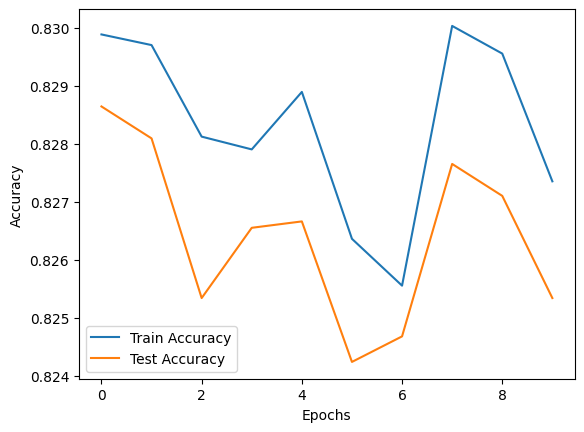

In [22]:
#Plotting the values

plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Logistic Regression Model

In [24]:
# Instantiate the Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
lr_model = logistic_regression_model.fit(X_train, y_train)

# Make a prediction using the testing data
testing_predictions = lr_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Print the balanced_accuracy score of the model
balanced_accuracy = balanced_accuracy_score(y_test, testing_predictions)
print(f"Balanced Accuracy Score : {balanced_accuracy}")

# Generate a confusion matrix for the model
cm = confusion_matrix(y_test, testing_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

print("Confusion Matrix")
display(cm_df)

# Print the classification report for the model
print("Classification Report")
print(classification_report(y_test, testing_predictions))

Balanced Accuracy Score : 0.7342510620028797
Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5426,681
Actual 1,1244,1718


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6107
           1       0.72      0.58      0.64      2962

    accuracy                           0.79      9069
   macro avg       0.76      0.73      0.75      9069
weighted avg       0.78      0.79      0.78      9069



## Random Forest Model

In [26]:
# Split our preprocessed data into our features and target arrays
y = cleaned_df['booking_status'].values
X = cleaned_df.copy()
X.drop("booking_status", axis=1, inplace=True)
X.head()

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

<Axes: title={'center': 'Features Importance'}, ylabel='1'>

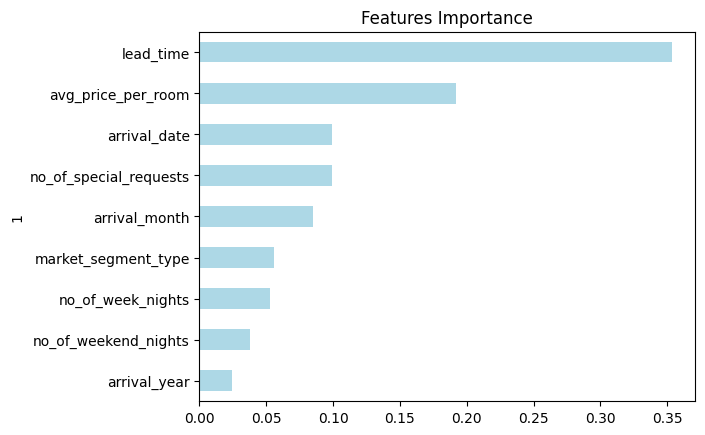

In [28]:
#Creating a dataframe that shows the features importance to be displayed

importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightblue', title= 'Features Importance', legend=False)

In [30]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5771,325
Actual 1,606,2367


Accuracy Score : 0.8973425956555299
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      6096
           1       0.88      0.80      0.84      2973

    accuracy                           0.90      9069
   macro avg       0.89      0.87      0.88      9069
weighted avg       0.90      0.90      0.90      9069

